# Supplemental Information Section G - Simulation of _dgoR_ promoter with multiple RNAP sites

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
#load tools
import scipy as sp
import numpy as np
import pandas as pd
from Bio import SeqIO
import math
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import sys
sys.path.insert(0, '../code/')
import NB_sortseq_utils as utils

# Seaborn, useful for graphics
import seaborn as sns

sns.set_palette("deep", color_codes=True)
utils.set_plotting_style1()

datadir = 'input_data/'

In [9]:
# function to mutate a given sequence (change p for mutation rate)
def seq_mut(seq,p):
    """
    Input: sequence to be mutated
    Output: mutated sequence where mutation rate is defined by
    p, where the probability of each transition is 25% (with the
    transition to itself not allowed).
    """
    seq_dict = {0:'A',1:'C',2:'G',3:'T'}
    seq_mut = ''
    for i,bp in enumerate(seq):
        p = np.random.uniform(low=0.0, high=1.0)
        if p >= 0.9:
            seq_temp = seq[i]
            while seq[i] == seq_temp:
                t = np.random.randint(low =0,high=4)
                seq_temp = seq_dict[t]
            seq_mut += seq_temp
        else:
            seq_mut += seq[i]
    return seq_mut

In [10]:
#------------------------------------------------------------------------------#
# make mutated library
#------------------------------------------------------------------------------#

RNAP_full = 'TTTTTATGCATTGTTCTTTTTGTGATCTAAATTGTAGTACAACAATATAAGTTTGTACTACATTA'

RNAP_WT = 'TTTTTATGCA'
RNAP_mut_region = 'TTGTTCTTTTTGTGATCTAAATTGTAGTACAACAATATAAGTTTGTACTACATTA'

#Lets generate our library of mutated sequences ; of size N_seq
N_seq = 5*10**6
wt_pdgor_mut_array = ["" for x in range(N_seq)]
for i,bp in enumerate(wt_pdgor_mut_array):
    wt_pdgor_mut_array[i] = RNAP_WT + seq_mut(RNAP_mut_region,0.9)

#Save to txt so that we don't have to rerun this
np.savetxt(datadir + '20170814_dgoR_sequences_10percentMut.txt',
           wt_pdgor_mut_array , fmt="%s")

In [11]:
#------------------------------------------------------------------------------#
# load mutated library
#------------------------------------------------------------------------------#

RNAP_full = 'TTTTTATGCATTGTTCTTTTTGTGATCTAAATTGTAGTACAACAATATAAGTTTGTACTACATTA'

RNAP_WT = 'TTTTTATGCA'
RNAP_mut_region = 'TTGTTCTTTTTGTGATCTAAATTGTAGTACAACAATATAAGTTTGTACTACATTA'

wt_pdgor_mut_array = np.loadtxt(datadir +
       '20170814_dgoR_sequences_10percentMut.txt' ,dtype='str')

In [16]:
#------------------------------------------------------------------------------#
# calculate energies based on RNAP matrix
#------------------------------------------------------------------------------#
ematdir = 'input_data/'
emat = '20150513_relB_MG1655_M9glucose_na_mut1_4bins_RNAP_emat_mean_plusspacer1bp.csv'
emat_promoter = 'relB'

# Load in energy matrix
emat_RNAP = pd.read_csv(ematdir + emat)

# fix matrix gauge; leave in a.u. energy units to compare multiple binding sites
emat_RNAP = utils.fix_matrix_gauge(np.array(emat_RNAP[['A','C','G','T']].T)[:,1:31])
# we're going to ignore the bp on each end (padding) of the RNAP matrix
len_emat = 30

# collect 5*10**6 per bin
N_seq = 5*10**6

# compute energies for each operator sequence
#seqs1 = sp.zeros((4,30,N_seq),dtype=int)
seqs2 = sp.zeros((4,30,N_seq),dtype=int)
seqs3 = sp.zeros((4,30,N_seq),dtype=int)

for j in range(0,N_seq):
    #seqs1[:,:,j] = seq2mat(wt_pdgor_mut_array[j][3:33])
    seqs2[:,:,j] = utils.seq2mat(wt_pdgor_mut_array[j][13:43])
    seqs3[:,:,j] = utils.seq2mat(wt_pdgor_mut_array[j][34:-1])

# calculate energies across all sequences in library

# dot1 = np.array(emat_RNAP)[:,:,sp.newaxis]*seqs1
# energies_RNAP1 = dot1.sum(0).sum(0)

dot2 = np.array(emat_RNAP)[:,:,sp.newaxis]*seqs2
energies_RNAP2 = dot2.sum(0).sum(0)

dot3 = np.array(emat_RNAP)[:,:,sp.newaxis]*seqs3
energies_RNAP3 = dot3.sum(0).sum(0)




We now need to estimate the expression distribution of our library. We are assuming that the underlying features that determine expression can be captured by a model of multiple constitutively expressed RNAP binding sites.
We will calculate expression across the library by calculating $P_{bound}$ (Bintu et al. 2005), which for two RNAP
binding sites, we have,

$$P_{bound} = \frac{ \alpha_1 \frac{P}{N_{NS}} e^{-\beta \varepsilon_{pd_1}} + \alpha_2 \frac{P}{N_{NS}} e^{-\beta \varepsilon_{pd_2}}}
{1 + \alpha_1 \frac{P}{N_{NS}} e^{-\beta \varepsilon_{pd_1}} + \alpha_2 \frac{P}{N_{NS}} e^{-\beta \varepsilon_{pd_2}}} $$

and let $\alpha_1$=$\alpha_2$.

In [22]:
# Calculate expression by estimating P_bound (Bintu et al. 2005)
# (i.e. pbound \propto alpha1 P_1/N exp(energies_1) +
# alpha2 P_2/N exp(energies_2) + ... ); let alpha1=alpha2=...

#Lets place these arrays in a Pandas dataframe for ease of handling
df =  pd.DataFrame(wt_pdgor_mut_array)
df.columns = ['RNAP full Sequence']
# df['RNAP site 1 energy prediction'] = pd.DataFrame(energies_RNAP1)
df['RNAP site 2 energy prediction'] = pd.DataFrame(energies_RNAP2)
df['RNAP site 3 energy prediction'] = pd.DataFrame(energies_RNAP3)

# define concentratino of RNAP
P = 3000 # approx number per cell
#let add some noise to make it more realizstic
df['P'] = np.random.normal(P, P*0.25,len(df['RNAP full Sequence']))

# calculate Pbound
# p1_state = np.exp(-df['RNAP site 1 energy prediction'])
p2_state = np.exp(-df['RNAP site 2 energy prediction'])
p3_state = np.exp(-df['RNAP site 3 energy prediction'])

N_ns = 4.6E6

# calculate tau = P_bound; i.e. expression
df['tau'] = ( (df['P']/N_ns) *( p2_state ) + (df['P']/N_ns) * (p3_state))/ (1 +  (df['P']/N_ns) *( p2_state ) + (df['P']/N_ns) *( p3_state ))

Lets plot the distribution of expression across our library.

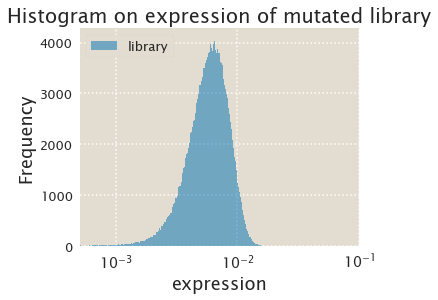

In [25]:
#Plot the distribution of expression
fig = plt.figure(1, figsize(5, 4))
plt.hist(df['tau'][df['tau']>=0], bins = 5000 ,label = 'library', alpha = 0.5)
plt.title("Histogram on expression of mutated library")
plt.xlabel("expression")
plt.ylabel("Frequency")
plt.xscale('log')
plt.xlim(5E-4,0.1)
plt.legend(loc=2)
plt.show()

We can also plot the distribution from a single promoter sequence, assuming we were to
sample many times given our distributino of RNAP in cells. Shown below, we see the distribution
is narrower than our library as expected.

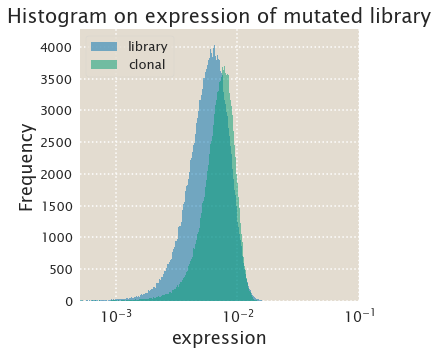

In [29]:
# calculate tau = P_bound; i.e. expression
df['tau_single'] =  ( (df['P']/N_ns) *( p2_state[0] ) + (df['P']/N_ns) * (p3_state[0]))/ (1 +  (df['P']/N_ns) *( p2_state[0] ) + (df['P']/N_ns) *( p3_state[0] ))
#Plot the distribution of expression
fig = plt.figure(1, figsize(5, 5))
plt.hist(df['tau'][df['tau']>=0], bins = 5000 ,label = 'library', alpha = 0.5)
plt.hist(df['tau_single'][df['tau_single']>=0], bins = 5000 ,label = 'clonal', alpha = 0.5)
plt.title("Histogram on expression of mutated library")
plt.xlabel("expression")
plt.ylabel("Frequency")
plt.xscale('log')
plt.xlim(5E-4,0.1)
plt.legend(loc=2)
plt.show()

In [ ]:
#------------------------------------------------------------------------------#
# sort cells into four bins of 15% windows and save as fasta files
#------------------------------------------------------------------------------#

# identify the log(expression) percentile values for each of our 'FACS' sorts.
tau = 'tau'
p1 = np.percentile(df[tau], 15)
p2 = np.percentile(df[tau], 25)
p3 = np.percentile(df[tau], 40)
p4 = np.percentile(df[tau], 60)
p5 = np.percentile(df[tau], 75)
p6 = np.percentile(df[tau], 85)

df_bin1 = df[df[tau] <= p1]
df_bin2 = df[(df[tau] >= p2) & (df[tau] <= p3)]
df_bin3 = df[(df[tau] >= p4) & (df[tau] <= p5)]
df_bin4 = df[df[tau] >= p6]


#now we need to save our binned data as fasta files for later analysis
#I might be making more work for myself by converting to _scalefactor3.fasta

fname = '20170822_pdgor_1RNAP_' + emat_promoter + 'bin'
#since the library sequences were randomly generated, I'm just going to
#take the first 200,000 sequences in eachbin.
count = 0
file = open(datadir + 'sortedseq/' + fname + '1.fasta', "w")
while count <= 2*10**5:
    file.write(">")
    file.write(str(count))
    file.write("\n")
    file.write(df_bin1['RNAP full Sequence'].values[count][10:])
    file.write("\n")
    count += 1
file.close()

count = 0
file = open(datadir + 'sortedseq/' + fname + '2.fasta', "w")
while count <= 2*10**5:
    file.write(">")
    file.write(str(count))
    file.write("\n")
    file.write(df_bin2['RNAP full Sequence'].values[count][10:])
    file.write("\n")
    count += 1
file.close()

count = 0
file = open(datadir + 'sortedseq/' + fname + '3.fasta', "w")
while count <= 2*10**5:
    file.write(">")
    file.write(str(count))
    file.write("\n")
    file.write(df_bin3['RNAP full Sequence'].values[count][10:])
    file.write("\n")
    count += 1
file.close()

count = 0
file = open(datadir + 'sortedseq/' + fname + '4.fasta', "w")
while count <= 2*10**5:
    file.write(">")
    file.write(str(count))
    file.write("\n")
    file.write(df_bin4['RNAP full Sequence'].values[count][10:])
    file.write("\n")
    count += 1
file.close()

